In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import json
from sklearn.model_selection import train_test_split
import warnings
import os
from PIL import Image
import matplotlib.pyplot as plt

from utils.dataloader import *
from models import Create_nets

In [2]:
def plot_allbars(df, args):
    '''
    Plots all the bars and ratios from a dataset
    '''
    df_filtered = df[df['categories'].isin(['Train', 'Test'])]

    fig, ax = plt.subplots(figsize=(20, 8))
    plt.grid(alpha=0.3)
    unique_classes = df_filtered['class'].unique()
    x_positions = range(len(unique_classes))
    positions = {'Train': -0.2, 'Test': 0.2}
    
    # Create a mapping from class labels to their positions
    class_to_pos = {cls: pos for cls, pos in zip(unique_classes, x_positions)}

    # Plot stacked bar chart with specified colors
    for idx, category in enumerate(df_filtered['categories'].unique()):
        print(idx, category)
        grp = df_filtered[df_filtered['categories'] == category]
        if category == 'Train':
            color_good = 'dodgerblue'
            color_anomaly = 'orange'
        else:
            color_good = 'darkblue'
            color_anomaly = 'red'
        
        bar_positions = [class_to_pos[cls] + positions[category] for cls in grp['class']]
        
        bars_good = ax.bar(bar_positions, grp['good_images'], width=0.4, color=color_good, label=f'Good Images - {category}' if idx == 0 else "", align='center')
        bars_anomalies = ax.bar(bar_positions, grp['anomalies'], bottom=grp['good_images'], width=0.4, color=color_anomaly, label=f'Anomalies - {category}' if idx == 0 else "", align='center')
        
        # Add ratios on top of the bars
        for bar, ratio in zip(bars_anomalies, grp['ratios']):
            height = bar.get_height() + bar.get_y()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{ratio:.2f}', ha='center', va='bottom')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{args.data_set} - Contamination Rate: {args.contamination_rate}')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(unique_classes)
    ax.legend()

    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='dodgerblue', lw=4, label='Good Train'),
        Line2D([0], [0], color='darkblue', lw=4, label='Good Test'),
        Line2D([0], [0], color='orange', lw=4, label='Anomaly Train'),
        Line2D([0], [0], color='red', lw=4, label='Anomaly Test')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    plt.grid(alpha=0.3)
    plt.show()

### Dataset

In [3]:
class ImageDataset_mvtec(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_loco = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        

        if self.args.mode=='mvtec_loco':
            img = self.resize_transform_loco(img)       

        
        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            
            if 'good' in filename:    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 0
            else:   
                # different ground truth schema for mvtec_loco
                if self.args.mode=='mvtec_loco':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "/000.png"))                        
                if self.args.mode=='mvtec':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "_mask.png"))
                
                ground_truth = self.resize_transform_loco(ground_truth)  
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files)


In [4]:
class ImageDataset_beantec(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_bean = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        img = self.resize_transform_bean(img)

        
        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            
            if 'ok' in os.path.split(filename)[0].split(os.sep):    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 0
            else:   
 
                ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".bmp", ".png"))
                
                ground_truth = self.resize_transform_bean(ground_truth)  
                
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files)

In [5]:
class ImageDataset_visa(Dataset):
    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):
        
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        
        self.resize_transform_visa = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if mode == 'train':
            self.files = train_paths
        elif mode == 'test':
            self.files = test_paths
            
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask
    
    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(filename)
        img = img.convert('RGB')
        img = self.resize_transform_visa(img)

        if self.mode == 'train':
            img = self.transform_train(img)            
            return filename, img
        
        elif self.mode == 'test':
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            if 'Normal' in os.path.split(filename)[0].split(os.sep):    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                return filename, img, ground_truth, 0
            else:   
                ground_truth = Image.open(filename.replace("Images", "Masks").replace(".JPG", ".png"))
                ground_truth = self.resize_transform_visa(ground_truth)  
                img, ground_truth = transform_test(img, ground_truth) 
                
                ground_truth=(ground_truth > 0).float()
                # TODO check for mask if resized correctly
                return filename, img, ground_truth, 1
            
    def __len__(self):
        return len(self.files) 


### get paths for the sets

In [6]:
def get_paths_mvtec_loco(args,verbose=True):
    

    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/good')
    VALIDATION_PATH = os.path.join(DATA_PATH, f'{category}/validation/good')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
    file_path = []
    for root, dirs, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "good" not in item]
    good_images_test=[item for item in file_path if "good" in item]
    
    normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    validation_images=[os.path.join(VALIDATION_PATH,item) for item in os.listdir(VALIDATION_PATH)]

    
    n_samples = int((len(normal_images)+len(validation_images))*args.contamination_rate)
    valid_train_ratio=float(len(validation_images)/(len(normal_images)+len(validation_images)))
    
    
    
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test,anomaly_categories[category], n_samples, args.seed)

    if validation:
        warnings.warn(f"Vaidation split is set to {validation_split}, but the dataset is already split into train and validation sets by publisher. Ignoring validation split ratio.")
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=valid_train_ratio, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []

    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
        
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [7]:
def get_paths_mvtec(args,verbose=True):
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/good')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
        
    normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    file_path = []
    for root, _, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "good" not in item]
    good_images_test=[item for item in file_path if "good" in item]
    

    ## TODO changes fixed seed
    n_samples = int(len(normal_images)*args.contamination_rate)
    
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []

    print("debug","got to load the data")
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [8]:
def get_paths_beantec(args,verbose=True):
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    DATA_PATH=args.data_root
    
    NORMAL_PATH = os.path.join(DATA_PATH, f'{category}/train/ok')
    ANOMALY_PATH = os.path.join(DATA_PATH , f'{category}/test')
    
        
        
    ## TODO for class "03" only half the paths
    if category=="03":
        normal_images=args.dataset_parameters["reduced_train_paths"]["03"]
        
    else:   
        normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
    
    
    
    file_path = []
    for root, _, files in os.walk(ANOMALY_PATH):
        for file in files:
            file_path.append( os.path.join(root, file))
        
    anomaly_images_test=[item for item in file_path if "ok" not in os.path.split(item)[0].split(os.sep)]
    good_images_test=[item for item in file_path if "ok" in os.path.split(item)[0].split(os.sep)]
    

    
    n_samples = int(len(normal_images)*args.contamination_rate)
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []
        
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test

In [9]:

def get_paths_visa(args,verbose=True):
    
    DATA_PATH=args.data_root
    
    
    df = pd.read_csv(os.path.join(DATA_PATH,'split_csv/1cls.csv')) # use split 1
    
    
    anomaly_categories=args.dataset_parameters['anomaly_categories']
    category=args.data_category
    validation=args.dataset_parameters['use_validation']
    validation_split=args.dataset_parameters['validation_split']
    
    
    category=args.data_category

    df_cat=df[df['object']==category]
    df_test=df_cat[df_cat['split']=='test']

    normal_train=df_cat[df_cat['split']=='train']['image'].values.tolist()
    normal_test=df_test[df_test['label']=='normal']['image'].values.tolist()
    anomaly_test=df_test[df_test['label']=='anomaly']['image'].values.tolist()
    
    normal_images=[os.path.join(DATA_PATH,item) for item in normal_train]
    good_images_test=[os.path.join(DATA_PATH,item) for item in normal_test]
    anomaly_images_test=[os.path.join(DATA_PATH,item) for item in anomaly_test]
    
    if args.fixed_n_normals != None and args.fixed_n_normals <= len(normal_images):
        normal_images= random.sample(normal_images, args.fixed_n_normals)
    
    n_samples = int(len(normal_images)*args.contamination_rate)
        
    
    
    sampled_anomalies_for_train, remaining_anomalies_test = stratified_sample(anomaly_images_test, anomaly_categories[category], n_samples, args.test_seed)

    if validation_split > 0:
        if validation!= True:
            raise ValueError('validation_split is set to > 0 but use_validation is set to False')
        normal_images,validation_images = train_test_split(normal_images, test_size=validation_split, random_state=args.seed)
        sampled_anomalies_for_train, sampled_anomalies_for_val = train_test_split(sampled_anomalies_for_train, test_size=validation_split, random_state=args.seed)
    else:
        sampled_anomalies_for_val = []
        validation_images = []
        
    if verbose:
        print(f'category: {category}, normals train:  {len(normal_images)}, anomalies test: {len(anomaly_images_test)}, normal test: {len(good_images_test)}')       
        print(f'anomalies test total:     {count_files_by_class(anomaly_images_test, anomaly_categories[category])}')
        print(f'anomalies test sampled:   {count_files_by_class(sampled_anomalies_for_train, anomaly_categories[category])}')
        print(f'anomalies test remaining: {count_files_by_class(remaining_anomalies_test, anomaly_categories[category])}')
    
    return normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test



In [10]:
def get_dataloader(args):

    if args.mode == 'mvtec' or args.mode == 'mvtec_loco':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)
                print("sucessfully loaded experiment paths")   
                
        else:    
            if args.mode == 'mvtec':    
                normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
                
            if args.mode == 'mvtec_loco':
                normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec_loco(args,verbose=True)

            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        
        if args.use_synthetic:
            
            # use synthetic trainig data
            if args.mode != 'mvtec':
                raise ValueError("Synthetic data is only available for mvtec yet")
            
            training_dataset=MVTecSynthAnoDataset(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None)
            train_dataloader = DataLoader(training_dataset,batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
            
            if len(experiment_paths['valid']) > 0:
                valid_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                    batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
            else:
                valid_dataloader = None
                
            test_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
            
            
        #####   use no synthetic data  
        else:
            train_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                            batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
            if len(experiment_paths['valid']) > 0:
                valid_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                    batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
            else:
                valid_dataloader = None
            test_dataloader = DataLoader(ImageDataset_mvtec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
            


    if args.mode == 'beantec':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)     
                
        else:    
            normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_beantec(args,verbose=True)    
            
            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        train_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                        batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
        if len(experiment_paths['valid']) > 0:
            valid_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
        else:
            valid_dataloader = None
        test_dataloader = DataLoader(ImageDataset_beantec(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),
                                                        batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)

    if args.mode == 'visa':
        
        EXPERIMENT_LOG_PATH = os.path.join(args.results_dir,args.data_set ,
                                    f'contamination_{int(args.contamination_rate*100)}',
                                    f'{args.exp_name}-{args.data_category}')
        
        if os.path.exists(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json")) and not args.development:
            with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "r") as file:
                experiment_paths = json.load(file)     
                
        else:    
            normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_visa(args,verbose=True)    
            
            # sample from train paths if less trainming data should be used
            train_paths = normal_images + sampled_anomalies_for_train
            train_paths=random.sample(train_paths,int(len(train_paths)*args.data_ratio))
            left_out_train_paths = list(set(normal_images + sampled_anomalies_for_train) - set(train_paths))
            valid_paths = validation_images + sampled_anomalies_for_val
            test_paths = good_images_test + remaining_anomalies_test
            experiment_paths={'train':train_paths,'test':test_paths,'valid':valid_paths,'leftout_train_paths':left_out_train_paths,'contamination_rate':args.contamination_rate,'seed':args.seed}
            
            if not args.development:
                os.makedirs(EXPERIMENT_LOG_PATH, exist_ok=True)
                with open(os.path.join(EXPERIMENT_LOG_PATH,"experiment_paths.json"), "w") as file:
                    json.dump(experiment_paths, file)
        
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        train_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='train',train_paths = experiment_paths['train'],test_paths = None),
                                                        batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)
        if len(experiment_paths['valid']) > 0:
            valid_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['valid']),
                                                batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)
        else:
            valid_dataloader = None
        test_dataloader = DataLoader(ImageDataset_visa(args,DATA_PATH,mode='test',train_paths = None,test_paths = experiment_paths['test']),
                                                        batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)    
    
    if args.mode == 'utrad_mvtec':
        
        if args.contamination_rate != 0.0:
            raise ValueError("Contamination rate should be 0.0 for clean original implementation")
        DATA_PATH=os.path.join(args.data_root,args.data_category)
        
        train_dataloader = DataLoader(ImageDataset(args,DATA_PATH, mode='train'),
                                                    batch_size=args.batch_size, shuffle=True, num_workers=args.n_cpu, drop_last=False)
        test_dataloader = DataLoader(ImageDataset(args, DATA_PATH, mode='test'),
                            batch_size=args.batch_size, shuffle=False, num_workers=1, drop_last=False)


    return train_dataloader,valid_dataloader, test_dataloader

MVTEC


debug got to load the data
category: carpet, normals train:  280, anomalies test: 89, normal test: 28
anomalies test total:     {'color': 19, 'cut': 17, 'hole': 17, 'metal_contamination': 17, 'thread': 19}
anomalies test sampled:   {'color': 0, 'cut': 0, 'hole': 0, 'metal_contamination': 0, 'thread': 0}
anomalies test remaining: {'color': 19, 'cut': 17, 'hole': 17, 'metal_contamination': 17, 'thread': 19}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/003.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/041.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/190.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/088.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/092.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/000.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/126.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/089.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/223.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/185.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/067.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/273.png', '/home/bule/pro

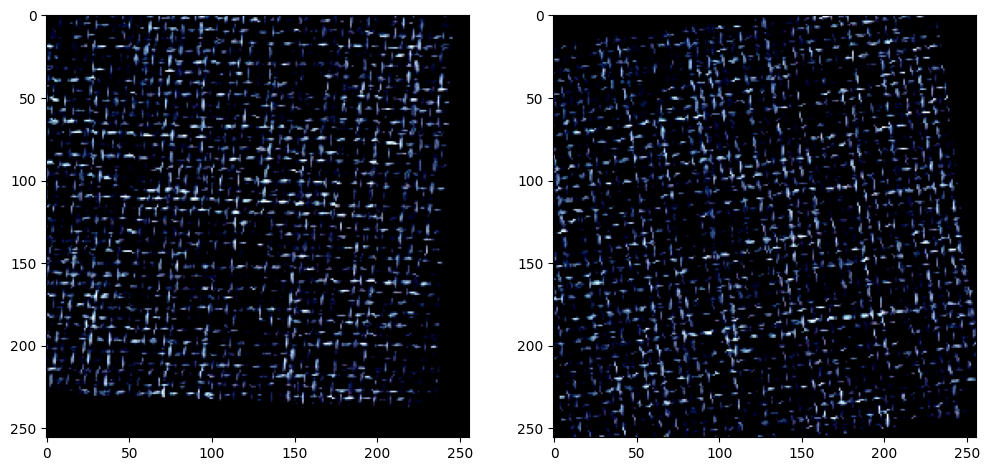

In [25]:
category='carpet'

anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]}


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self, category=category):
        self.exp_name = "DEV_DATALOADER"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = False
        self.test_seed = 400
        self.data_ratio = 0.5
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = category
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.0
        self.validation= 0.0
        self.data_set = 'mvtec'
        self.mode = 'mvtec'
        self.results_dir = 'results'
        self.development = False
        self.use_synthetic=False
        
        
args = TrainOptions()
#torch.manual_seed(args.seed)
import time
import numpy as np


if not args.fixed_seed_bool:
    args.test_seed = int(time.time())
    args.seed = int(time.time())

torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)    
    

try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)



try:
    images, tensor = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tensor[0].permute(1, 2, 0).numpy())
axes[1].imshow(tensor[1].permute(1, 2, 0).numpy())
plt.show()

debug got to load the data
category: bottle, normals train:  209, anomalies test: 63, normal test: 20
anomalies test total:     {'broken_large': 20, 'broken_small': 22, 'contamination': 21}
anomalies test sampled:   {'broken_large': 0, 'broken_small': 0, 'contamination': 0}
anomalies test remaining: {'broken_large': 20, 'broken_small': 22, 'contamination': 21}
debug got to load the data
category: cable, normals train:  224, anomalies test: 92, normal test: 58
anomalies test total:     {'bent_wire': 13, 'cable_swap': 12, 'combined': 11, 'cut_inner_insulation': 14, 'cut_outer_insulation': 10, 'missing_cable': 12, 'missing_wire': 10, 'poke_insulation': 10}
anomalies test sampled:   {'bent_wire': 0, 'cable_swap': 0, 'combined': 0, 'cut_inner_insulation': 0, 'cut_outer_insulation': 0, 'missing_cable': 0, 'missing_wire': 0, 'poke_insulation': 0}
anomalies test remaining: {'bent_wire': 13, 'cable_swap': 12, 'combined': 11, 'cut_inner_insulation': 14, 'cut_outer_insulation': 10, 'missing_cable

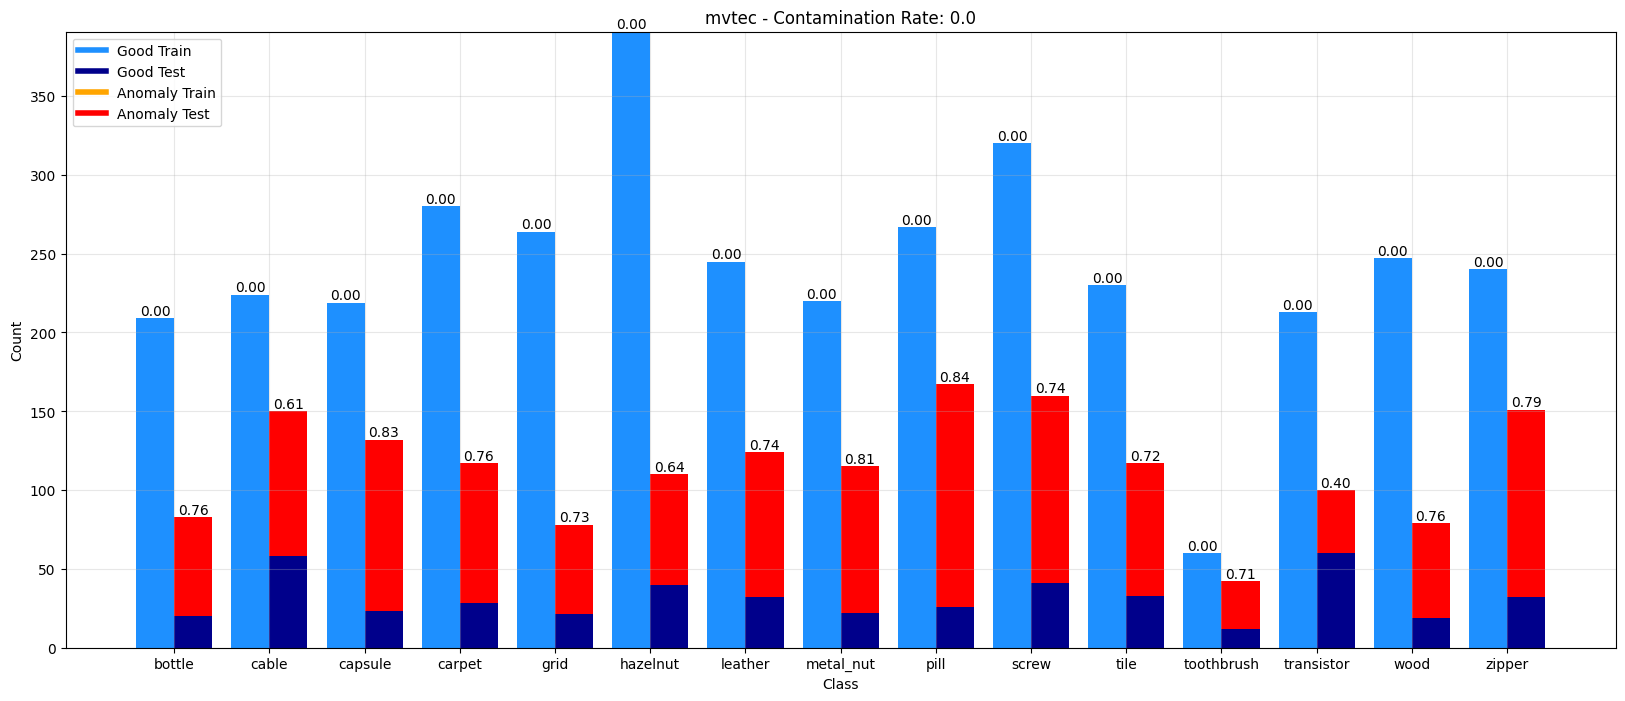

In [26]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] /(good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]
    
    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])
    
    
    # fig, ax = plt.subplots(figsize=(10, 6))
    # bar_width = 0.5
    # bar1 = np.arange(len(categories))
    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')
    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()
    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')
    # plt.show()
    
plot_allbars(res_df,args)

MVTEC LOCO

In [13]:
# loco
anomaly_categories = {
    'breakfast_box': ['logical_anomalies', 'structural_anomalies'],
    'juice_bottle': ['logical_anomalies', 'structural_anomalies'],
    'pushpins': ['logical_anomalies', 'structural_anomalies'],
    'screw_bag': ['logical_anomalies', 'structural_anomalies'],
    'splicing_connectors': ['logical_anomalies', 'structural_anomalies'],
}

#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='breakfast_box'):
        self.exp_name = "Exp_20_02_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/'
        self.data_category = category
        self.data_ratio = 0.1
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'mvtec_loco'
        self.mode = 'mvtec_loco'
        self.results_dir = 'results'
        self.development = True
        self.use_synthetic=False
               
args = TrainOptions()
torch.manual_seed(args.seed)

print(args.data_category)

try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
    print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
    
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)

try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")


breakfast_box
Configuration file for mvtec_loco found. Proceeding with parameters.
category: breakfast_box, normals train:  351, anomalies test: 173, normal test: 102
anomalies test total:     {'logical_anomalies': 83, 'structural_anomalies': 90}
anomalies test sampled:   {'logical_anomalies': 19, 'structural_anomalies': 21}
anomalies test remaining: {'logical_anomalies': 64, 'structural_anomalies': 69}
('/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/test/structural_anomalies/014.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/121.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/306.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/test/logical_anomalies/060.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/240.png', '/home/bule/projects/datasets/mvtec_loco_anomaly_detection/breakfast_box/train/good/307.png', '

Configuration file for mvtec_loco found. Proceeding with parameters.
category: breakfast_box, normals train:  351, anomalies test: 173, normal test: 102
anomalies test total:     {'logical_anomalies': 83, 'structural_anomalies': 90}
anomalies test sampled:   {'logical_anomalies': 19, 'structural_anomalies': 21}
anomalies test remaining: {'logical_anomalies': 64, 'structural_anomalies': 69}
Configuration file for mvtec_loco found. Proceeding with parameters.
category: juice_bottle, normals train:  335, anomalies test: 236, normal test: 94
anomalies test total:     {'logical_anomalies': 142, 'structural_anomalies': 94}
anomalies test sampled:   {'logical_anomalies': 22, 'structural_anomalies': 15}
anomalies test remaining: {'logical_anomalies': 120, 'structural_anomalies': 79}
Configuration file for mvtec_loco found. Proceeding with parameters.
category: pushpins, normals train:  372, anomalies test: 172, normal test: 138
anomalies test total:     {'logical_anomalies': 91, 'structural_an

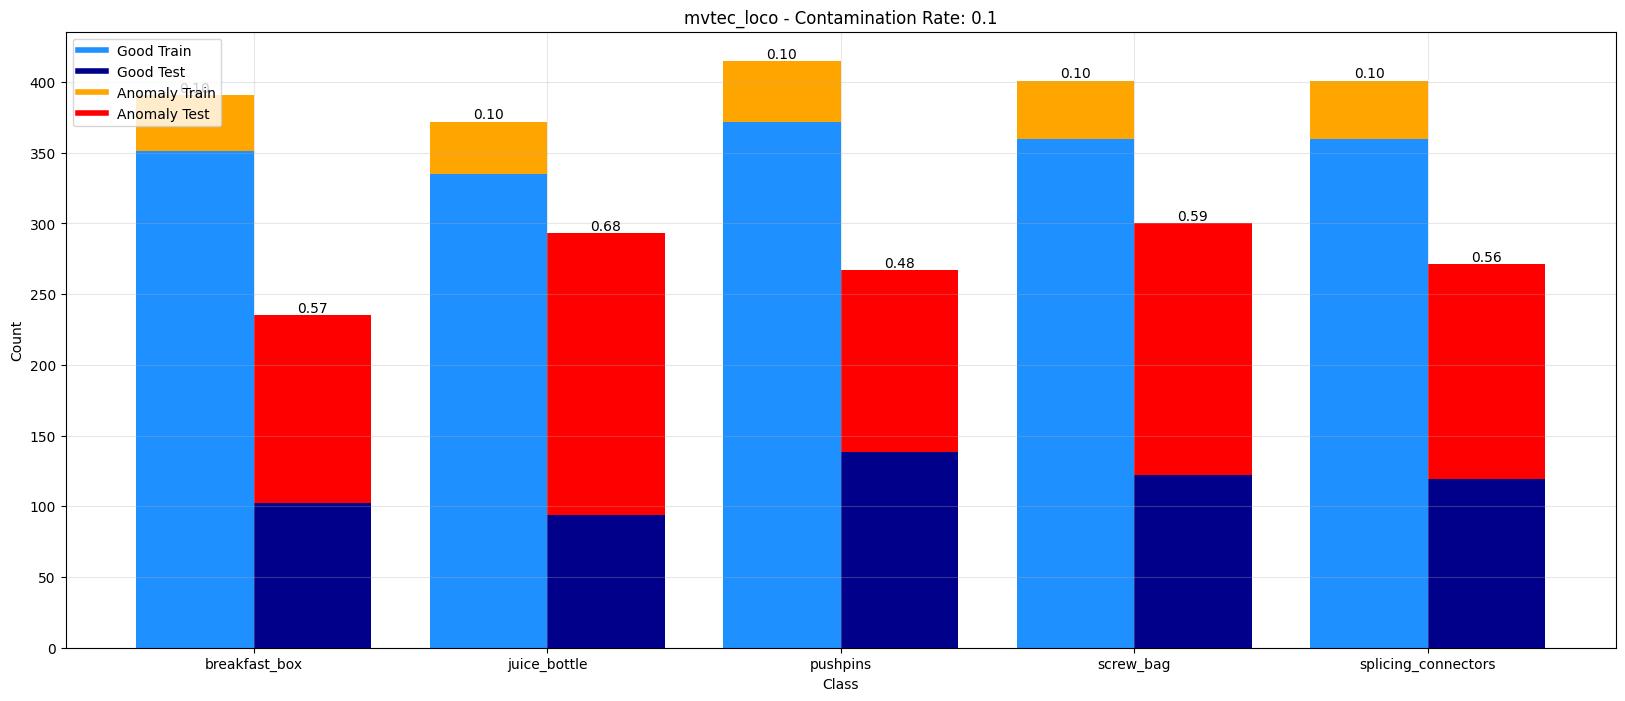

In [14]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
    
        
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec_loco(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]
    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])
    # fig, ax = plt.subplots(figsize=(10, 6))

    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()


    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')


    # plt.show()
    
plot_allbars(res_df,args)

BEANTEC

In [15]:
# beantec
anomaly_categories={
    "01": ["ko"],
    "02": ["ko"],
    "03": ["ko"]}


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='01'):
        self.exp_name = "Exp_19_06_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/BTech_Dataset_transformed'
        self.data_category = category
        self.batch_size = 20
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.data_ratio = 1.0
        self.test_seed = 400    
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'beantec'
        self.mode = 'beantec'
        self.results_dir = 'results'
        self.development = True
               
args = TrainOptions()
torch.manual_seed(args.seed)


try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)
dataiter = iter(train_dataloader)

try:
    images, _ = next(dataiter) 
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")




category: 01, normals train:  400, anomalies test: 49, normal test: 21
anomalies test total:     {'ko': 49}
anomalies test sampled:   {'ko': 40}
anomalies test remaining: {'ko': 9}
('/home/bule/projects/datasets/BTech_Dataset_transformed/01/test/ko/0015.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0029.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0347.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0212.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/test/ko/0012.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0125.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0291.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0022.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0095.bmp', '/home/bule/projects/datasets/BTech_Dataset_transformed/01/train/ok/0363.bmp', '/home/bule/projects/datasets/

Configuration file for beantec found. Proceeding with parameters.
category: 01, normals train:  400, anomalies test: 49, normal test: 21
anomalies test total:     {'ko': 49}
anomalies test sampled:   {'ko': 40}
anomalies test remaining: {'ko': 9}
Configuration file for beantec found. Proceeding with parameters.
category: 02, normals train:  399, anomalies test: 200, normal test: 30
anomalies test total:     {'ko': 200}
anomalies test sampled:   {'ko': 39}
anomalies test remaining: {'ko': 161}
Configuration file for beantec found. Proceeding with parameters.
category: 03, normals train:  292, anomalies test: 82, normal test: 800
anomalies test total:     {'ko': 82}
anomalies test sampled:   {'ko': 29}
anomalies test remaining: {'ko': 53}
0 Train
1 Test


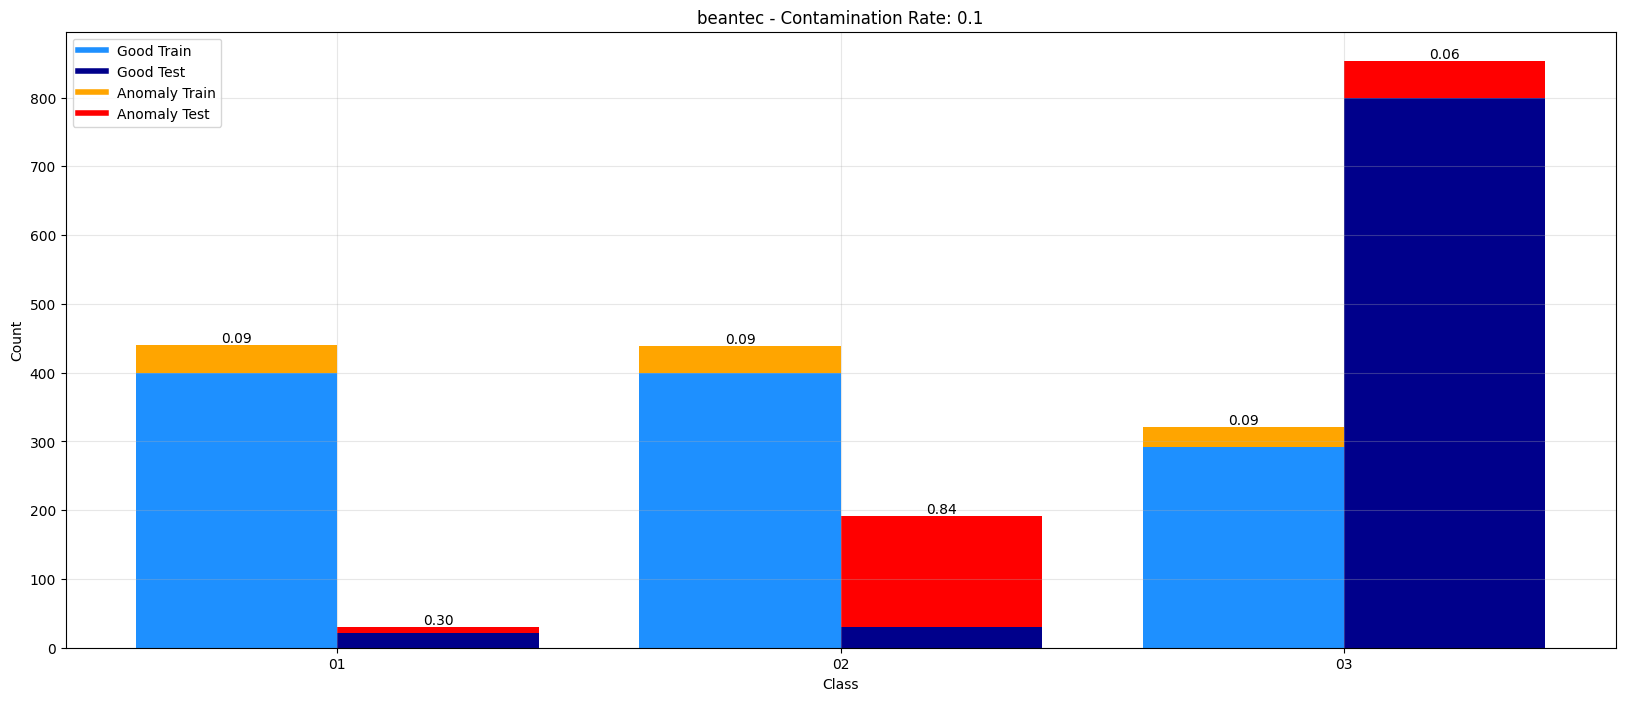

In [16]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
    
        
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_beantec(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]

    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]



    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    
    res_df=pd.concat([res_df,df_class])
    
    # fig, ax = plt.subplots(figsize=(10, 6))

    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()


    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')



plot_allbars(res_df,args)

VISA

category: candle, normals train:  250, anomalies test: 100, normal test: 100
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remaining: {'Anomaly': 75}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


type of img: <class 'torch.Tensor'>, shape of img: torch.Size([2, 3, 256, 256]) dtype of img: torch.float32
('/home/bule/projects/datasets/VisA/candle/Data/Images/Normal/0898.JPG', '/home/bule/projects/datasets/VisA/candle/Data/Images/Normal/0634.JPG')
anomalies per batch: {'Anomaly': 0}


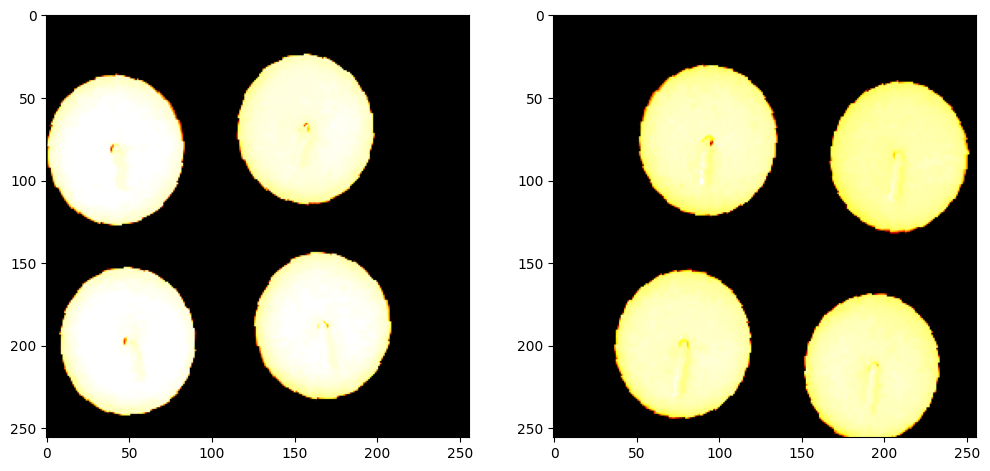

('/home/bule/projects/datasets/VisA/candle/Data/Images/Normal/0790.JPG', '/home/bule/projects/datasets/VisA/candle/Data/Images/Normal/0107.JPG')
torch.Size([2, 3, 256, 256])
tensor(0.) tensor(0.)
anomalies per batch: {'Anomaly': 0}


In [23]:
# visa
anomaly_categories={
    "candle": ["Anomaly"],
    "capsules": ["Anomaly"],
    "cashew": ["Anomaly"],
    "chewinggum":["Anomaly"],
    "fryum": ["Anomaly"],
    "macaroni1": ["Anomaly"],
    "macaroni2": ["Anomaly"],
    "pcb1":["Anomaly"],
    "pcb2":["Anomaly"],
    "pcb3":["Anomaly"],
    "pcb4": ["Anomaly"],
    "pipe_fryum": ["Anomaly"]
    }


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self,category='candle'):
        self.exp_name = "Exp_19_06_24"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/VisA'
        self.data_category = category
        self.batch_size = 2
        self.data_ratio = 1.0
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.fixed_n_normals = 250
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.validation= 0.0
        self.data_set = 'visa'
        self.mode = 'visa'
        self.results_dir = 'results'
        self.development = True
        
args = TrainOptions()
torch.manual_seed(args.seed)


try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})


train_dataloader, valid_dataloader , test_dataloader = get_dataloader(args)

dataiter = iter(train_dataloader)

try:
    images, tensor = next(dataiter) 
    
    print(f'type of img: {type(tensor)}, shape of img: {tensor.shape} dtype of img: {tensor.dtype}')
    print(images)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")
 
 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tensor[0].permute(1, 2, 0).numpy())
axes[1].imshow(tensor[1].permute(1, 2, 0).numpy())
plt.show()
   
dataiter_test = iter(test_dataloader)   

try:
    filename, img, ground_truth, _ = next(dataiter_test) 
    print(filename)# Use next() function to get the next batch
    print(img.size())
    print(ground_truth.max(),ground_truth.min())
    print(f'anomalies per batch: {count_files_by_class(images, anomaly_categories[args.data_category])}')

except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")

 
    

category: candle, normals train:  250, anomalies test: 100, normal test: 100
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remaining: {'Anomaly': 75}
category: capsules, normals train:  250, anomalies test: 100, normal test: 60
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remaining: {'Anomaly': 75}
category: cashew, normals train:  250, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remaining: {'Anomaly': 75}
category: chewinggum, normals train:  250, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remaining: {'Anomaly': 75}
category: fryum, normals train:  250, anomalies test: 100, normal test: 50
anomalies test total:     {'Anomaly': 100}
anomalies test sampled:   {'Anomaly': 25}
anomalies test remain

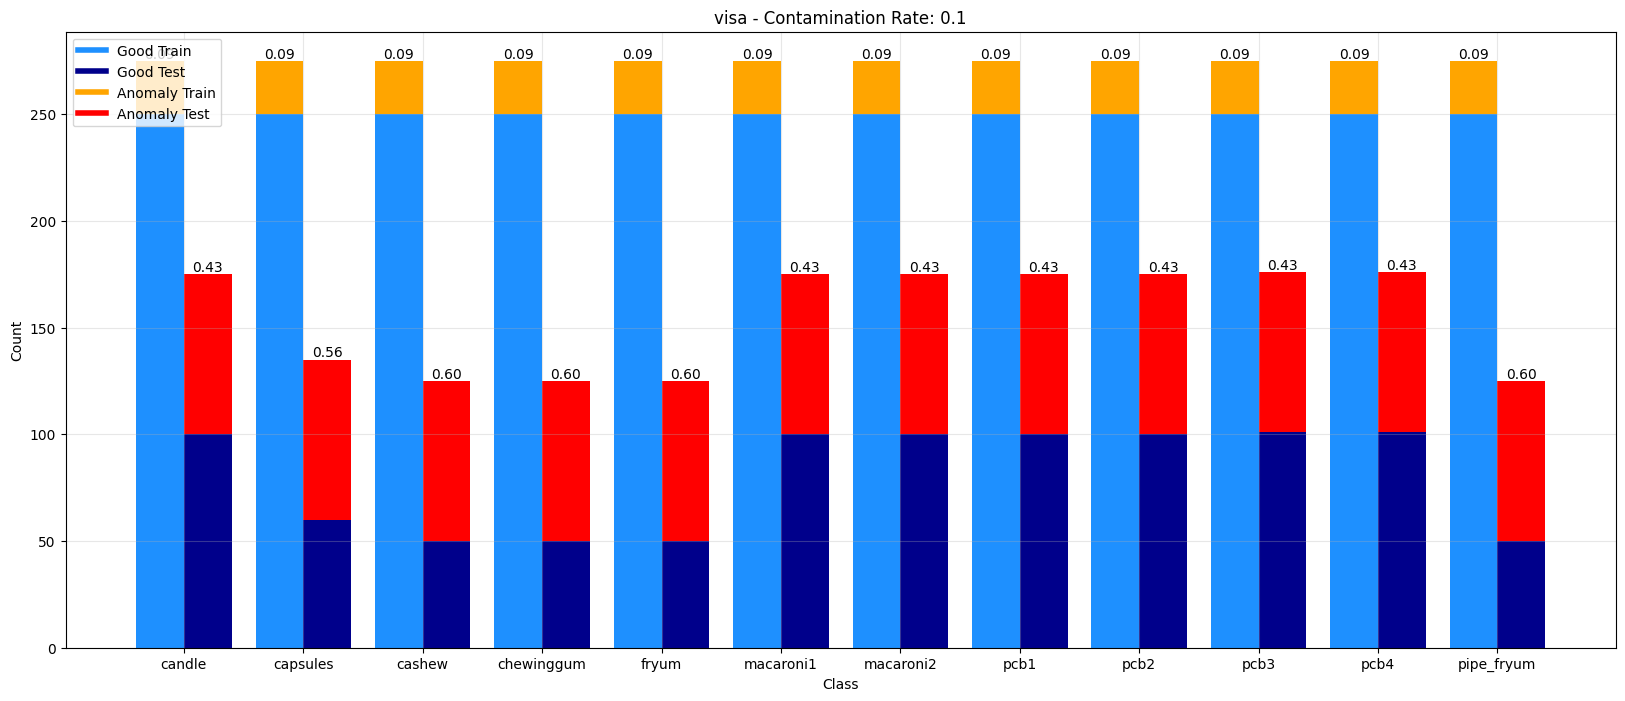

In [24]:
res_df=pd.DataFrame({'class':[],'categories':[],'good_images':[],'anomalies':[],'ratios':[]})

for key in anomaly_categories.keys():
    args = TrainOptions(category=key)
    try:
        with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
            dataset_parameters = json.load(file)
        setattr(args, 'dataset_parameters', dataset_parameters)
        # print(f"Configuration file for {args.data_set} found. Proceeding with parameters.")
        
    except FileNotFoundError:
        print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
        setattr(args, 'dataset_parameters', {})
        
    normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_visa(args,verbose=True)
    categories = ['Train', 'Test', 'Validation']
    good_images = [len(normal_images), len(good_images_test), len(validation_images)]
    anomalies = [len(sampled_anomalies_for_train), len(remaining_anomalies_test), len(sampled_anomalies_for_val)]
    ratios = [anomalies[i] / (good_images[i]+anomalies[i]) if good_images[i] != 0 else 0 for i in range(len(categories))]

    df_class=pd.DataFrame({'class':[key]*len(categories),'categories':categories,'good_images':good_images,'anomalies':anomalies,'ratios':ratios})
    res_df=pd.concat([res_df,df_class])

    # fig, ax = plt.subplots(figsize=(10, 6))
    # bar_width = 0.5
    # bar1 = np.arange(len(categories))

    # p1 = ax.bar(bar1, good_images, bar_width, label='Good Images', color='skyblue')
    # p2 = ax.bar(bar1, anomalies, bar_width, bottom=good_images, label='Anomalies', color='lightcoral')

    # ax.set_xlabel('Image Categories')
    # ax.set_ylabel('Number of Images')
    # ax.set_title(f'Contaminated {args.contamination_rate} data for category: {args.data_category} dataset: {args.data_set}')
    # ax.set_xticks(bar1)
    # ax.set_xticklabels(categories)
    # ax.legend()
    # for i in range(len(categories)):
    #     ax.text(bar1[i], good_images[i] / 2, f'{good_images[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] / 2, f'{anomalies[i]}', ha='center', va='center', color='black')
    #     ax.text(bar1[i], good_images[i] + anomalies[i] + 5, f'Ratio: {ratios[i]:.2f}', ha='center')

    # plt.show()
    
plot_allbars(res_df,args)

# Synthetic dataloader

https://github.com/HuiZhang0812/DiffusionAD/blob/main/data/dataset_beta_thresh.py

## MVTEC

In [19]:
import os
import torch
import math
import numpy as np
import os
import numpy as np
from torch.utils.data import Dataset
import torch
import cv2
import glob
import imgaug.augmenters as iaa
from PIL import Image
from torchvision import transforms
import random
from torch.utils.data import DataLoader



# from data.perlin import rand_perlin_2d_np

texture_list = ['carpet', 'zipper', 'leather', 'tile', 'wood','grid',
                'Class1', 'Class2', 'Class3', 'Class4', 'Class5',
                'Class6', 'Class7', 'Class8', 'Class9', 'Class10']

category='carpet'

anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]}


#args = TrainOptions().parse() # surpass kernelerror with this:
class TrainOptions:
    def __init__(self, category='carpet'):
        self.exp_name = "DEV_DATALOADER"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = False
        self.test_seed = 400
        self.data_ratio = 0.5
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.synthetic_anomaly_root = '/home/bule/projects/datasets/dtd'
        self.data_category = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.0
        self.validation= 0.0
        self.data_set = 'mvtec'
        self.mode = 'mvtec'
        self.results_dir = 'results'
        self.development = False
        self.use_synthetic=True
        self.synthetic_ratio=0.5

args = TrainOptions()
torch.manual_seed(args.seed)
        
DATA_PATH=os.path.join(args.data_root,args.data_category)

In [20]:

def lerp_np(x,y,w):
    fin_out = (y-x)*w + x
    return fin_out

def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise


def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2 * np.pi * np.random.rand(res[0] + 1, res[1] + 1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1, 1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:, 1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:, :, 0], grid[:, :, 1] - 1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:, :, 0] - 1, grid[:, :, 1] - 1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00 * (1 - t[:, :, 0]) + t[:, :, 0] * n10
    n1 = n01 * (1 - t[:, :, 0]) + t[:, :, 0] * n11
    return np.sqrt(2) * ((1 - t[:, :, 1]) * n0 + t[:, :, 1] * n1)


def rand_perlin_2d_np(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):  #shape (256 256) res (16,2))
    delta = (res[0] / shape[0], res[1] / shape[1]) #(1/16,1,128)
    d = (shape[0] // res[0], shape[1] // res[1])  #(16,128)
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1   #delta 为间隔 0:res[0]为上下界。 (256,256,2)

    angles = 2 * math.pi * np.random.rand(res[0] + 1, res[1] + 1)    #(17,3)
    gradients = np.stack((np.cos(angles), np.sin(angles)), axis=-1)  #(17,3,2)
    tt = np.repeat(np.repeat(gradients,d[0],axis=0),d[1],axis=1) # (272,384,2)

    tile_grads = lambda slice1, slice2: np.repeat(np.repeat(gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]],d[0],axis=0),d[1],axis=1)
    dot = lambda grad, shift: (
                np.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            axis=-1) * grad[:shape[0], :shape[1]]).sum(axis=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0]) #(256,256)
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]]) #(256,256,2)
    return math.sqrt(2) * lerp_np(lerp_np(n00, n10, t[..., 0]), lerp_np(n01, n11, t[..., 0]), t[..., 1]) #(256,256)

"""
def rand_perlin_2d(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])

    #grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1]), indexing='ij'), dim=-1) % 1
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(
        0, res[1], delta[1])), dim=-1) % 1    
    angles = 2 * math.pi * torch.rand(res[0] + 1, res[1] + 1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)

    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0],
                                                                                                              0).repeat_interleave(
        d[1], 1)
    dot = lambda grad, shift: (
                torch.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :shape[1], 1] + shift[1]),
                            dim=-1) * grad[:shape[0], :shape[1]]).sum(dim=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0, 0])

    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1, -1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])
"""

"\ndef rand_perlin_2d(shape, res, fade=lambda t: 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3):\n    delta = (res[0] / shape[0], res[1] / shape[1])\n    d = (shape[0] // res[0], shape[1] // res[1])\n\n    #grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1]), indexing='ij'), dim=-1) % 1\n    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(\n        0, res[1], delta[1])), dim=-1) % 1    \n    angles = 2 * math.pi * torch.rand(res[0] + 1, res[1] + 1)\n    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)\n\n    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0],\n                                                                                                              0).repeat_interleave(\n        d[1], 1)\n    dot = lambda grad, shift: (\n                torch.stack((grid[:shape[0], :shape[1], 0] + shift[0], grid[:shape[0], :

In [21]:



texture_list = ['carpet', 'zipper', 'leather', 'tile', 'wood','grid',
                'Class1', 'Class2', 'Class3', 'Class4', 'Class5',
                 'Class6', 'Class7', 'Class8', 'Class9', 'Class10']

class MVTecSynthAnoDataset(Dataset):

    def __init__(self, args, root, transforms_=None, mode='train', train_paths=None, test_paths=None):


        #data_path,classname,img_size,args

        ##################### origianl loader
        self.img_size = 280 * args.factor
        self.crop_size = 256 * args.factor
        self.args = args
        self.mode = mode
        if train_paths is None and test_paths is None:
            raise ValueError("either test or train paths must be provided depending on the mode")
        
        self.train_paths = train_paths
        self.test_paths = test_paths
        
        if mode == 'train':
            self.files = train_paths
            
        elif mode == 'test':
            self.files = test_paths
            
        
        print(f"Number of images in {mode} mode: {len(self.files)}")
        
        self.transform_train = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                                transforms.RandomRotation(10),
                                                transforms.RandomCrop((self.crop_size, self.crop_size)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ]) ])
        ########################################

        self.resize_transform_loco = transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC)

        self.classname=args.data_category
        
        self.root_dir = os.path.join(root,'train','good')
        self.resize_shape = [self.crop_size, self.crop_size]
        self.anomaly_source_path = args.synthetic_anomaly_root
        
        

        self.image_paths = train_paths
        self.anomaly_source_paths = sorted(glob.glob(self.anomaly_source_path+"/images/*/*.jpg"))

        self.augmenters = [iaa.GammaContrast((0.5, 2.0), per_channel=True),
                           iaa.MultiplyAndAddToBrightness(
                               mul=(0.8, 1.2), add=(-30, 30)),
                           iaa.pillike.EnhanceSharpness(),
                           iaa.AddToHueAndSaturation(
                               (-50, 50), per_channel=True),
                           iaa.Solarize(0.5, threshold=(32, 128)),
                           iaa.Posterize(),
                           iaa.Invert(),
                           iaa.pillike.Autocontrast(),
                           iaa.pillike.Equalize(),
                           iaa.Affine(rotate=(-45, 45))
                           ]
        
        self.augmenters_anomaly = [iaa.GammaContrast((0.5, 2.0), per_channel=True),
                           iaa.MultiplyAndAddToBrightness(
                               mul=(0.8, 1.2), add=(-30, 30)),
                           iaa.pillike.EnhanceSharpness(),
                           iaa.AddToHueAndSaturation(
                               (-50, 50), per_channel=True),
                           iaa.Solarize(0.5, threshold=(32, 128)),
                           iaa.Posterize(),
                           iaa.Invert(),
                           iaa.pillike.Autocontrast(),
                           iaa.pillike.Equalize(),
                           ]

        self.augmenters_mask = [iaa.Affine(rotate=(-90, 90)),
                              iaa.Affine(shear=(0, 40)),
                           iaa.Affine(translate_percent={"x": (-0.5, 0.5), "y": (-0.5, 0.5)}),]
        
        self.rot = iaa.Sequential([iaa.Affine(rotate=(-90, 90))])
        

        #foreground path of textural classes
        foreground_path = os.path.join(args.data_root,'carpet')
        self.textural_foreground_path = sorted(glob.glob(foreground_path +"/thresh/*.png"))

    def __len__(self):
        return len(self.files)
    
    def _align_transform(self, img, mask):
        #resize to 224
        img = TF.resize(img, self.crop_size, Image.BICUBIC)
        mask = TF.resize(mask, self.crop_size, Image.NEAREST)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def _unalign_transform(self, img, mask):
        #resize to 256
        img = TF.resize(img, self.img_size, Image.BICUBIC)
        mask = TF.resize(mask, self.img_size, Image.NEAREST)
        #random rotation
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        mask = TF.rotate(mask, angle, fill=(0,))
        #random crop
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.crop_size, self.crop_size))
        img = TF.crop(img, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        #toTensor
        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)
        #normalize
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        return img, mask

    def random_choice_foreground_path(self):
        foreground_path_id = torch.randint(0, len(self.textural_foreground_path), (1,)).item()
        foreground_path = self.textural_foreground_path[foreground_path_id]
        return foreground_path


    def get_foreground_mvtec(self,image_path):
        classname = self.classname
        if classname in texture_list:
            foreground_path = self.random_choice_foreground_path()
        else:
            foreground_path = image_path.replace('train', 'DISthresh')
        return foreground_path



    def randAugmenter_anomaly(self):
        aug_ind = np.random.choice(
            np.arange(len(self.augmenters_anomaly)), 2, replace=False)
        aug = iaa.Sequential([self.augmenters_anomaly[aug_ind[0]],
                              self.augmenters_anomaly[aug_ind[1]]]
                             )
        return aug

    def randAugmenter_mask(self):
        aug_ind = np.random.choice(
            np.arange(len(self.augmenters_mask)), 1, replace=False)
        aug = iaa.Sequential([self.augmenters_mask[aug_ind[0]],]
                             )
        return aug


    def randAugmenter(self):
        aug_ind = np.random.choice(
            np.arange(len(self.augmenters)), 3, replace=False)
        aug = iaa.Sequential([self.augmenters[aug_ind[0]],
                              self.augmenters[aug_ind[1]],
                              self.augmenters[aug_ind[2]]]
                             )
        return aug


    def perlin_synthetic(self, image, thresh, anomaly_source_path, cv2_image,thresh_path):

    # no_anomaly = torch.rand(1).numpy()[0]
    # if no_anomaly > 0.5:
    #     image = image.astype(np.float32)
    #     return image, np.zeros((self.resize_shape[0], self.resize_shape[1], 1), dtype=np.float32), np.array([0.0], dtype=np.float32)

    # else:
        perlin_scale = 6  
        min_perlin_scale = 0
        perlin_scalex = 2 ** (torch.randint(min_perlin_scale,perlin_scale, (1,)).numpy()[0])
        perlin_scaley = 2 ** (torch.randint(min_perlin_scale,perlin_scale, (1,)).numpy()[0])

        has_anomaly = 0
        try_cnt = 0
        while(has_anomaly == 0 and try_cnt<50):  
            perlin_noise = rand_perlin_2d_np(
                (self.resize_shape[0], self.resize_shape[1]), (perlin_scalex, perlin_scaley))
            perlin_noise = self.rot(image=perlin_noise)
            threshold = 0.5
            perlin_thr = np.where(perlin_noise > threshold, np.ones_like(perlin_noise), np.zeros_like(perlin_noise))
            
            object_perlin = thresh*perlin_thr

            object_perlin = np.expand_dims(object_perlin, axis=2).astype(np.float32)  

            msk = (object_perlin).astype(np.float32) 
            if np.sum(msk) !=0: 
                has_anomaly = 1        
            try_cnt+=1
            
        
        if self.classname in texture_list: # only DTD
            print('texture selected')
            aug = self.randAugmenter()
            anomaly_source_img = cv2.cvtColor(cv2.imread(anomaly_source_path),cv2.COLOR_BGR2RGB)
            anomaly_source_img = cv2.resize(anomaly_source_img, dsize=(
                self.resize_shape[1], self.resize_shape[0]))
            anomaly_img_augmented = anomaly_source_img# aug(image=anomaly_source_img)# no aug
            img_object_thr = anomaly_img_augmented.astype(
                np.float32) * object_perlin/255.0
            
        else: # DTD and self-augmentation
            texture_or_patch = torch.rand(1).numpy()[0]
            if texture_or_patch > 0.5:  # >0.5 is DTD 
                aug = self.randAugmenter()
                anomaly_source_img = cv2.cvtColor(cv2.imread(anomaly_source_path),cv2.COLOR_BGR2RGB)
                anomaly_source_img = cv2.resize(anomaly_source_img, dsize=(
                    self.resize_shape[1], self.resize_shape[0]))
                anomaly_img_augmented = anomaly_source_img#aug(image=anomaly_source_img)
                anomaly_img_augmented = anomaly_source_img# aug(image=anomaly_source_img)# no aug
                img_object_thr = anomaly_img_augmented.astype(
                    np.float32) * object_perlin/255.0

            else: #self-augmentation
                aug = self.randAugmenter()
                anomaly_image = cv2_image#aug(image=cv2_image)#no aug
                high, width = anomaly_image.shape[0], anomaly_image.shape[1]
                gird_high, gird_width = int(high/8), int(width/8)
                wi = np.split(anomaly_image, range(
                    gird_width, width, gird_width), axis=1)
                wi1 = wi[::2]
                random.shuffle(wi1)
                wi2 = wi[1::2]
                random.shuffle(wi2)
                width_cut_image = np.concatenate(
                    (np.concatenate(wi1, axis=1), np.concatenate(wi2, axis=1)), axis=1)
                hi = np.split(width_cut_image, range(
                    gird_high, high, gird_high), axis=0)
                random.shuffle(hi)
                hi1 = hi[::2]
                random.shuffle(hi1)
                hi2 = hi[1::2]
                random.shuffle(hi2)
                mixer_cut_image = np.concatenate(
                    (np.concatenate(hi1, axis=0), np.concatenate(hi2, axis=0)), axis=0)
                img_object_thr = mixer_cut_image.astype(
                    np.float32) * object_perlin/255.0

        beta = torch.rand(1).numpy()[0] * 0.6 + 0.2
        augmented_image = image * \
            (1 - object_perlin) + (1 - beta) * \
            img_object_thr + beta * image * (object_perlin)

        augmented_image = augmented_image.astype(np.float32)

        return augmented_image, msk, np.array([has_anomaly], dtype=np.float32)


    def __getitem__(self, index):
        
        
        
        filename = self.files[index]
        

        
        
        if self.mode == 'train':
            
            gets_anomaly_rand = torch.rand(1).numpy()[0]
            
            
            if gets_anomaly_rand > self.args.synthetic_ratio:
                has_anomaly=1
                
                image = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
                
                cv2_image=image
                thresh_path = self.get_foreground_mvtec(filename)
                
                print(f'thresh_path: {thresh_path}')
                
                thresh=cv2.imread(thresh_path,0)
                thresh = cv2.resize(thresh,dsize=(self.resize_shape[1], self.resize_shape[0]))

                thresh = np.array(thresh).astype(np.float32)/255.0 
                image = np.array(image).astype(np.float32)/255.0

                anomaly_source_idx = torch.randint(0, len(self.anomaly_source_paths), (1,)).item()
                anomaly_path = self.anomaly_source_paths[anomaly_source_idx]
                
                augmented_image, anomaly_mask, has_anomaly_per  = self.perlin_synthetic(image,thresh,anomaly_path,cv2_image,thresh_path)
                
                augmented_image = np.transpose(augmented_image, (2, 0, 1))
                image = np.transpose(image, (2, 0, 1))
                anomaly_mask = np.transpose(anomaly_mask, (2, 0, 1))
                
                
                print(np.shape(augmented_image))
                augmented_image=torch.from_numpy(augmented_image)
                
                print(f'type of img: {type(augmented_image)}, shape of img: {augmented_image.shape} dtype of img: {augmented_image.dtype}')
                
                
                
                
                to_pil = transforms.ToPILImage()
                pil_image = to_pil(augmented_image)
                augmented_image = self.transform_train(pil_image)   
                return filename, augmented_image, has_anomaly
            
            
            # if there is no anomaly created
            else:
                has_anomaly = 0
                #original resize and transform 
                # img = self.transform_train(img)      
                # with rand augmenter
                image = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
                # aug = self.randAugmenter()
                # image=aug(image=image)
                
                img = np.array(image).astype(np.float32)/255.0
                img=img.transpose(2, 0, 1)
                img=torch.from_numpy(img)
                
                
                to_pil = transforms.ToPILImage()
                pil_image = to_pil(img)
                img = self.transform_train(pil_image)  
                 
                 
                 
                return filename, img, has_anomaly
        
        elif self.mode == 'test':
            # img = Image.open(filename)
            # img = img.convert('RGB')
            
            image = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
            img = np.array(image).astype(np.float32)/255.0
            img=img.transpose(2, 0, 1)
            img=torch.from_numpy(img)
            to_pil = transforms.ToPILImage()
            img = to_pil(img)
            
            print(filename)
            
            transform_test = self._unalign_transform if self.args.unalign_test else self._align_transform
            img_size = (img.size[0], img.size[1])
            
            
            if 'good' in filename:    
                ground_truth =Image.new('L',(img_size[0],img_size[1]),0)
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 0
            else:   
                # different ground truth schema for mvtec_loco
                if self.args.mode=='mvtec_loco':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "/000.png"))                        
                if self.args.mode=='mvtec':
                    ground_truth = Image.open(filename.replace("test", "ground_truth").replace(".png", "_mask.png"))
                
                ground_truth = self.resize_transform_loco(ground_truth)  
                img, ground_truth = transform_test(img, ground_truth)
                
                return filename, img, ground_truth, 1


DATA_PATH=os.path.join(args.data_root,args.data_category)
trainimgs=[DATA_PATH+'/train/good/'+file for file in os.listdir(DATA_PATH+'/train/good')]
testpaths=[DATA_PATH+'/train/good/'+file for file in os.listdir(DATA_PATH+'/train/good')]


try:
    with open(os.path.join('configurations',f'{args.data_set}.json' ), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
    
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)

print(normal_images)

training_dataset=MVTecSynthAnoDataset(args,DATA_PATH,mode='train',train_paths = normal_images,test_paths = None)
train_dataloader = DataLoader(training_dataset,batch_size=args.batch_size,shuffle=True,num_workers=args.n_cpu,drop_last=False)

test_dataset=MVTecSynthAnoDataset(args,DATA_PATH,mode='test',train_paths = None ,test_paths = good_images_test+remaining_anomalies_test)
test_dataloader = DataLoader(test_dataset,batch_size=args.batch_size,shuffle=False,num_workers=1,drop_last=False)


dataiter_train = iter(train_dataloader)
dataiter_test = iter(test_dataloader)



debug got to load the data
category: carpet, normals train:  280, anomalies test: 89, normal test: 28
anomalies test total:     {'color': 19, 'cut': 17, 'hole': 17, 'metal_contamination': 17, 'thread': 19}
anomalies test sampled:   {'color': 0, 'cut': 0, 'hole': 0, 'metal_contamination': 0, 'thread': 0}
anomalies test remaining: {'color': 19, 'cut': 17, 'hole': 17, 'metal_contamination': 17, 'thread': 19}
['/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/236.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/182.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/087.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/127.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/148.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/054.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/112.png', '/home/bule/proj

thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/024.png


### TRAINSET with synthanos

thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/028.pngtexture selected

(3, 256, 256)thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/020.png

type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256]) dtype of img: torch.float32
thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/023.pngthresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/008.pngtexture selected


thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/014.png
(3, 256, 256)
type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256]) dtype of img: torch.float32
thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/025.png
/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/test/good/001.png
texture selected
texture selected
(3, 256, 256)
type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256

tensor([1, 1])
('/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/142.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/train/good/112.png')
anomalies per batch: {'color': 0, 'cut': 0, 'hole': 0, 'metal_contamination': 0, 'thread': 0}
dtype of img: <class 'torch.Tensor'>, shape of img: torch.Size([2, 3, 256, 256]) dtype of img: torch.float32


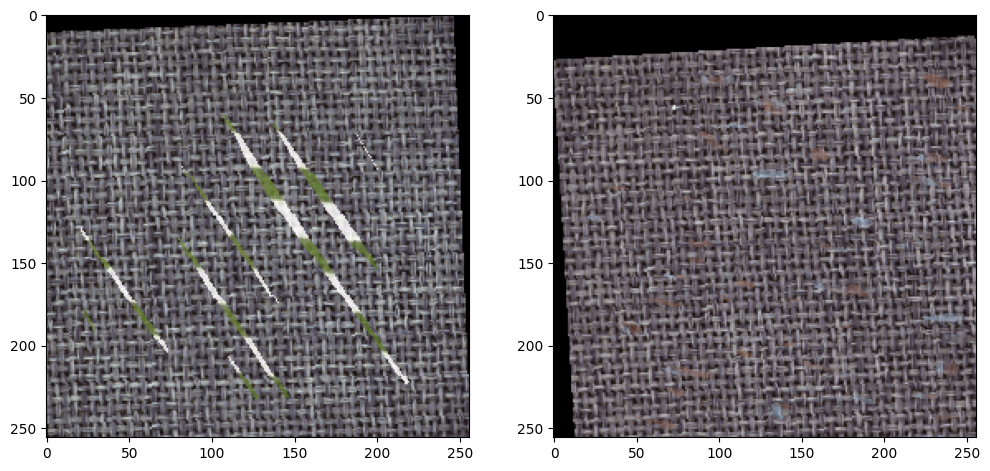

thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/028.pngthresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/020.png

texture selected
(3, 256, 256)
type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256]) dtype of img: torch.float32
texture selected
(3, 256, 256)
type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256]) dtype of img: torch.float32
thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/008.pngthresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/023.png

texture selected
(3, 256, 256)thresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/thresh/025.png

type of img: <class 'torch.Tensor'>, shape of img: torch.Size([3, 256, 256]) dtype of img: torch.float32
/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/test/good/001.pngthresh_path: /home/bule/projects/datasets/mvtec_anomaly_detection/carpet/th

In [ ]:
try:
    images_path, img ,has_ano = next(dataiter_train) 
    print(has_ano)
    print(images_path)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images_path, anomaly_categories[args.data_category])}')
    print(f'dtype of img: {type(img)}, shape of img: {img.shape} dtype of img: {img.dtype}')


except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")
    
    
# already scaled in the generator for imagenet values
img_min = img.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
img_max = img.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]
img = (img - img_min) / (img_max - img_min)
image1_rgb = img[0].permute(1, 2, 0).numpy()
image2_rgb = img[1].permute(1, 2, 0).numpy()
image1_bgr = image1_rgb[..., ::-1]
image2_bgr = image2_rgb[..., ::-1]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image1_bgr)
axes[1].imshow(image2_bgr)
plt.show()


### TESTSET

('/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/test/good/001.png', '/home/bule/projects/datasets/mvtec_anomaly_detection/carpet/test/good/011.png')
anomalies per batch: {'color': 0, 'cut': 0, 'hole': 0, 'metal_contamination': 0, 'thread': 0}
dtype of img: <class 'torch.Tensor'>, shape of img: torch.Size([2, 3, 256, 256]) dtype of img: torch.float32


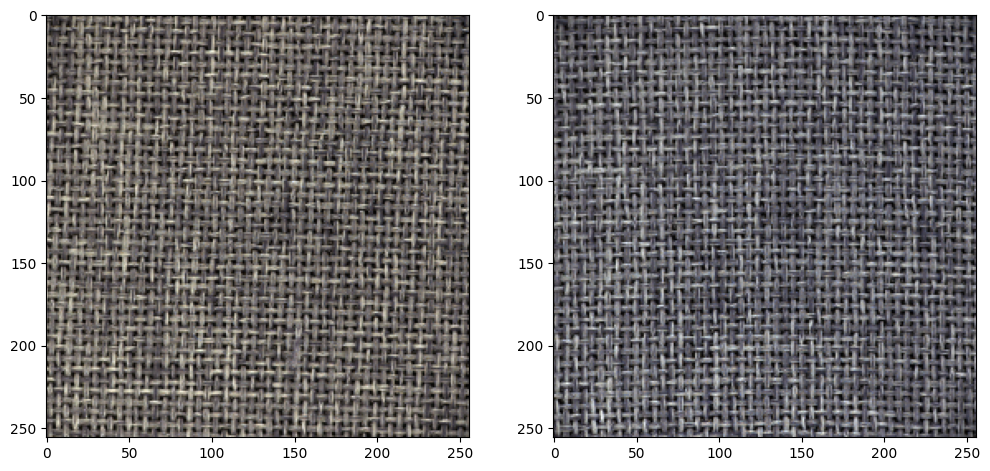

In [ ]:

try:
    images_path ,img, ground_truth, gt = next(dataiter_test) 
    print(images_path)# Use next() function to get the next batch
    print(f'anomalies per batch: {count_files_by_class(images_path, anomaly_categories[args.data_category])}')
    print(f'dtype of img: {type(img)}, shape of img: {img.shape} dtype of img: {img.dtype}')


except ValueError:  # Adjust this based on the structure your dataloader returns
    print("Error: Adjust the unpacking based on your dataloader's return value")
    
    
# already scaled in the generator for imagenet values
img_min = img.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
img_max = img.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]
img = (img - img_min) / (img_max - img_min)
image1_rgb = img[0].permute(1, 2, 0).numpy()
image2_rgb = img[1].permute(1, 2, 0).numpy()
image1_bgr = image1_rgb[..., ::-1]
image2_bgr = image2_rgb[..., ::-1]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image1_bgr)
axes[1].imshow(image2_bgr)
plt.show()